# Project 3 - EDA

## Table of Contents

- [Functions](#Functions)

- [Imports](#Imports)

- [Exploratory Data Analysis](#Exploratory-Data-Analysis) 

- [Model Pre-processing](#Model-Pre_Processing)




## Functions 

In [1]:

def data_dictionary(dframe):
    '''Creates a data dictionary of finished dataset'''
#Fill dictionary
    list_ = []
    for col in dframe.columns:
        Dict = {}
        Dict['Feature'] = col
        Dict['Data Type'] = dframe[col].dtype
        Dict['Dataset'] = 'df_fin.csv, df_econ.csv'
        list_.append(Dict)
#To dataframe format        
    d_dictionary = pd.DataFrame(list_)
    
#Add Description List to established dataframe
    description_list = ['The original poster of the reddit post', 'The date of the original post'
                            ,'The unique Id of the post','The initial title of the post','The amount of upvotes by other users; The relevance of the post',
                            'The number of comments in a post','The subreddit the post belongs to',
                            'The length of the characters in the title of the post','The word-count of the title', 'Words tokenized to remove whitespace'
                           , 'Words lemmatized to root of word (Based on analysis)', 'Stemmatized Words (Rudimentary chopping of words to root)', 
                        'One-Hot encoded variable showing whether a post is from Reddit Finance; used as our target variable']    
    column_values = pd.Series(description_list)
    d_dictionary.insert(loc=3, column='Description', value=column_values)
    d_dictionary.to_csv('./Data/Data_Dictionary.csv', index = False)

    return d_dictionary


## Imports

In [2]:
#Import Cleaning and Viz packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Import Modeling Libraries
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression


## Exploratory Data Analysis

In [3]:
df1 = pd.read_csv('./Data/reddit_posts.csv')
df_fin = pd.read_csv('./Data/fin_cleaned.csv')
df_econ= pd.read_csv('./Data/econ_cleaned.csv')



df1.head(2)

,author,date created (epoch time),post_id,body,upvote score,number of comments,subreddit,length,word_count,tokenized_words,lemmatized_tokenized_words,stemmatized_tokenized_words,post_reddit_finance
0,kmuinnovation,1631255155,plfj7f,Schweizer Kredit Rangliste des Monats Septembe...,1,0,Finance,52,7,"['schweizer', 'kredit', 'rangliste', 'des', 'm...","['schweizer', 'kredit', 'rangliste', 'de', 'mo...","['schweizer', 'kredit', 'ranglist', 'de', 'mon...",1
1,sillychillly,1631255546,plfm8v,Mastercard acquires CipherTrace to enhance cry...,1,0,Finance,62,7,"['mastercard', 'acquires', 'ciphertrace', 'to'...","['mastercard', 'acquires', 'ciphertrace', 'to'...","['mastercard', 'acquir', 'ciphertrac', 'to', '...",1


**Our dataframes are near parity with one another in terms of posts which means our null will likely be .5**

In [4]:
df1.describe()

,date created (epoch time),upvote score,number of comments,length,word_count,post_reddit_finance
count,2.000100e+04,20001.000000,20001.000000,20001.000000,20001.000000,20001.000000
mean,1.616534e+09,7.383231,21.016199,91.520574,13.212389,0.499975
std,8.752459e+06,156.396655,117.463195,68.779179,8.919074,0.500012
min,1.596237e+09,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.609778e+09,1.000000,0.000000,50.000000,8.000000,0.000000
50%,1.617132e+09,1.000000,0.000000,68.000000,11.000000,0.000000
75%,1.623881e+09,1.000000,2.000000,100.000000,16.000000,1.000000
max,1.631312e+09,12617.000000,4812.000000,307.000000,65.000000,1.000000


**Here we use one-hot encoding to get our target variable we are looking to predict later on.**

In [5]:
#Convert subreddit to dummies 1, if finance, 0 if econ

x = pd.get_dummies(df1, columns = ['subreddit'], drop_first = True)
df_fin= pd.get_dummies(df_fin, columns = ['subreddit'], drop_first = False)
df_econ = pd.get_dummies(df_econ, columns = ['subreddit'], drop_first = False)


df1['post_reddit_finance']= x['subreddit_Finance']



In [6]:
df1['post_reddit_finance'] = df1['post_reddit_finance'].astype(int)

In [7]:
df1.isna().sum()

author                         0
date created (epoch time)      0
post_id                        0
body                           0
upvote score                   0
number of comments             0
subreddit                      0
length                         0
word_count                     0
tokenized_words                0
lemmatized_tokenized_words     0
stemmatized_tokenized_words    0
post_reddit_finance            0
dtype: int64

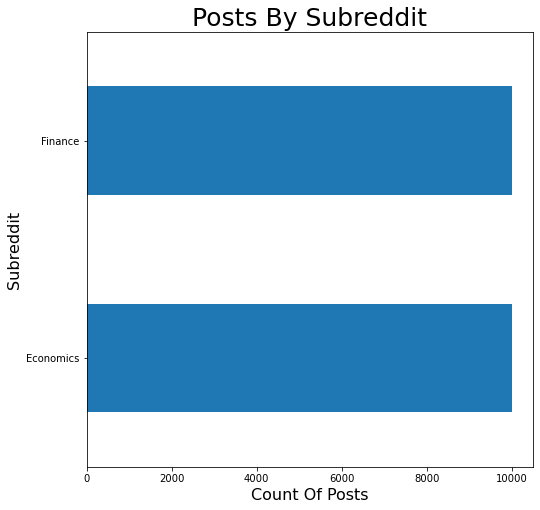

In [8]:
plt.figure(figsize=(8,8))
df1.subreddit.value_counts().plot(kind = 'barh')
plt.xlabel('Count Of Posts', fontsize=16)
plt.ylabel('Subreddit', fontsize=16)
plt.title('Posts By Subreddit', fontsize =25)

plt.show()

**Our subreddit contains the same number of posts, while our post dates range from 7/20/2020 (Finance) to 12/02/2020 (Economics)**

In [9]:
#Generate Look at largest by upvote score 
long_eda = df1.nlargest(10, ['upvote score'])
long_eda = long_eda[['body', 'upvote score', 'subreddit']]
short_eda = df1.nsmallest(5, ['upvote score'])
short_eda = short_eda[['body', 'upvote score', 'subreddit']]

pd.concat([long_eda, short_eda], ignore_index=True)

,body,upvote score,subreddit
0,The $7.25 minimum wage can’t pay the bills in ...,12617,Economics
1,Bipartisan bill would ban lawmakers from buyin...,11255,Finance
2,12 Japanese firms will end business deals invo...,5259,Economics
3,Californians on universal basic income paid of...,4326,Economics
4,A $15 minimum wage would have significant and ...,4047,Economics
5,"Melvin Capital Lost 53% in January, Hurt by Ga...",3957,Finance
6,Millennials Control Just 4.6 Percent of US Wealth,3678,Economics
7,More than 150 CEOs urge Congress to pass Biden...,3443,Economics
8,The decline of the American middle class began...,3270,Economics
9,Waiting 10 years to start eliminating emission...,3248,Economics


In [10]:
df1.nlargest(10, ['upvote score'])

,author,date created (epoch time),post_id,body,upvote score,number of comments,subreddit,length,word_count,tokenized_words,lemmatized_tokenized_words,stemmatized_tokenized_words,post_reddit_finance
16274,jayfreeze7,1614797668,lx1efi,The $7.25 minimum wage can’t pay the bills in ...,12617,2726,Economics,102,19,"['the', '7', '25', 'minimum', 'wage', 'can', '...","['the', '7', '25', 'minimum', 'wage', 'can', '...","['the', '7', '25', 'minimum', 'wage', 'can', '...",0
4717,Dull_Tonight,1614794779,lx09gp,Bipartisan bill would ban lawmakers from buyin...,11255,587,Finance,63,9,"['bipartisan', 'bill', 'would', 'ban', 'lawmak...","['bipartisan', 'bill', 'would', 'ban', 'lawmak...","['bipartisan', 'bill', 'would', 'ban', 'lawmak...",1
16561,monkfreedom,1614075485,lqf44i,12 Japanese firms will end business deals invo...,5259,330,Economics,71,11,"['12', 'japanese', 'firms', 'will', 'end', 'bu...","['12', 'japanese', 'firm', 'will', 'end', 'bus...","['12', 'japanes', 'firm', 'will', 'end', 'busi...",0
16227,speckz,1614867843,lxlmlv,Californians on universal basic income paid of...,4326,921,Economics,214,36,"['californians', 'on', 'universal', 'basic', '...","['californian', 'on', 'universal', 'basic', 'i...","['californian', 'on', 'univers', 'basic', 'inc...",0
17332,EconomicPolicy,1612277859,laxe0x,A $15 minimum wage would have significant and ...,4047,1827,Economics,82,14,"['a', '15', 'minimum', 'wage', 'would', 'have'...","['a', '15', 'minimum', 'wage', 'would', 'have'...","['a', '15', 'minimum', 'wage', 'would', 'have'...",0
5569,Imperial_in_NewYork,1612105132,l9dud0,"Melvin Capital Lost 53% in January, Hurt by Ga...",3957,744,Finance,67,12,"['melvin', 'capital', 'lost', '53', 'in', 'jan...","['melvin', 'capital', 'lost', '53', 'in', 'jan...","['melvin', 'capit', 'lost', '53', 'in', 'janua...",1
19283,jackahmed93,1608317922,kfr9f5,Millennials Control Just 4.6 Percent of US Wealth,3678,2831,Economics,49,8,"['millennials', 'control', 'just', '4', '6', '...","['millennials', 'control', 'just', '4', '6', '...","['millenni', 'control', 'just', '4', '6', 'per...",0
16462,zsreport,1614257473,ls5vyh,More than 150 CEOs urge Congress to pass Biden...,3443,641,Economics,69,12,"['more', 'than', '150', 'ceos', 'urge', 'congr...","['more', 'than', '150', 'ceo', 'urge', 'congre...","['more', 'than', '150', 'ceo', 'urg', 'congres...",0
17300,calmeagle11,1612320670,lbdqeg,The decline of the American middle class began...,3270,746,Economics,236,39,"['the', 'decline', 'of', 'the', 'american', 'm...","['the', 'decline', 'of', 'the', 'american', 'm...","['the', 'declin', 'of', 'the', 'american', 'mi...",0
17275,Splenda,1612361284,lbo9lk,Waiting 10 years to start eliminating emission...,3248,266,Economics,88,15,"['waiting', '10', 'years', 'to', 'start', 'eli...","['waiting', '10', 'year', 'to', 'start', 'elim...","['wait', '10', 'year', 'to', 'start', 'elimin'...",0


## EDA on Words

**Following a similar vectorizing process(not shown because you can only instantiate a vectorizer once in a doc), we determined the custom stop words we want to add. We will run the vectorizer to exclude these words, so that we have a better analysis. These words primarily stem from hyperlinks, file_type, and conjunctions**

In [11]:
#Custom stopwords we will add to model
custom_stop_word=['the', 'to','in','of', 'and', 'for', 
                  'is','on', 'with', 'com', 'https', 'www', 
                  'content', 'tinyurl', 'wp', 'uploads', 'jpg', '2020', 
                  '2021', 'new', 'pdf', 'amp', '10', '19', 'fintechinshorts', 'fintechnews', 'financial', 'economic', 'finance',
                  'financial', 'economy'] 

#Create stopwords variable
stopwords_1 = stopwords.words('english')
stopwords_1 = custom_stop_word + stopwords_1

In [12]:


#Setup label and message features
X = df1['body']
y = df1['post_reddit_finance']

#Create cross-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

# Instantiate a CountVectorizer with stop words

cvec = CountVectorizer(stop_words=stopwords_1)

cvec.fit(X_train)
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)



In [13]:
# use with Logistic Regression

lr_model = LogisticRegression()
lr_model.fit(X_train_cv, y_train)

score = lr_model.score(X_test_cv, y_test)
print('score:',score)

score: 0.7527078820196634


In [14]:
X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(25)


market       582
us           531
china        483
money        466
bank         465
currency     400
strength     392
covid        387
stock        376
weakness     367
inflation    356
global       351
bitcoin      329
world        320
business     313
tax          312
get          310
best         306
pandemic     298
year         289
may          288
online       283
first        273
crypto       264
imf          263
dtype: int64

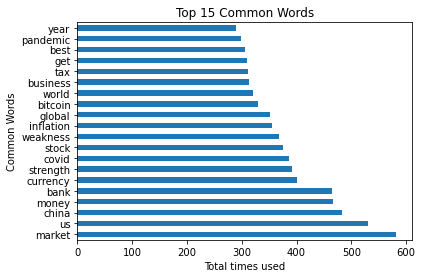

In [15]:
#Show common words
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');
plt.xlabel("Total times used")
plt.ylabel("Common Words")
plt.title("Top 15 Common Words");

## Analysis of Cleaned Files

**With our new stop words list, we will evaluate both sources of data to see commonalities in their text**

In [16]:
#Setup Fin Array
X = df_fin['body']
y = df_fin['subreddit_Finance']

In [17]:
cvec.fit(X)
X = cvec.transform(X)

In [18]:
fin = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())

In [19]:
#Setup Econ Array
X = df_econ['body']
y = df_econ['subreddit_Economics']

In [20]:
cvec.fit(X)
X = cvec.transform(X)

In [21]:
eco = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())

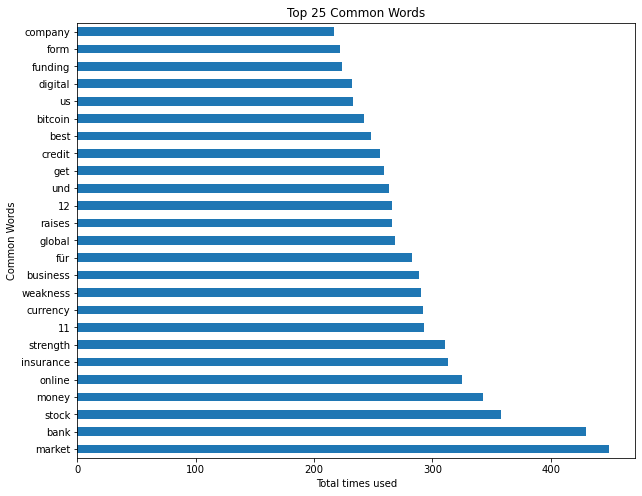

In [22]:
#Show common words

fin.sum().sort_values(ascending=False).head(25).plot(kind='barh', figsize=(10, 8));
plt.xlabel("Total times used")
plt.ylabel("Common Words")
plt.title("Top 25 Common Words")
figsize=(16,8);



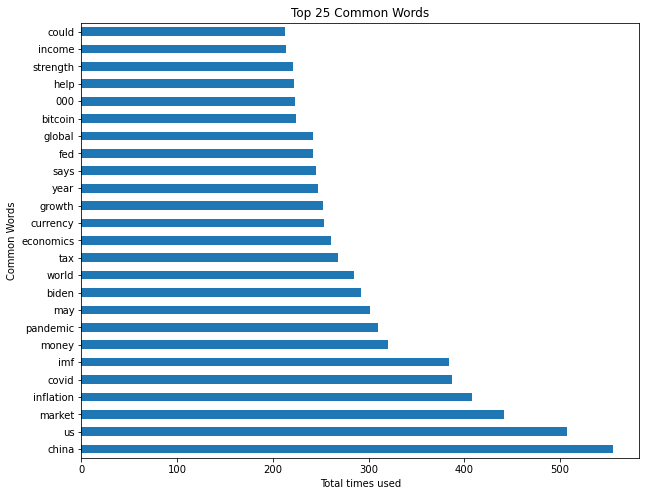

In [23]:
#Show common words


eco.sum().sort_values(ascending=False).head(25).plot(kind='barh',figsize=(10, 8));
plt.xlabel("Total times used")
plt.ylabel("Common Words")
plt.title("Top 25 Common Words");


**The data shows quite a bit of overlap between the two datasets. Words such as 'bitcoin', 'currency', 'global', 'world', 'market' are shared between the two subreddits, while there is a clear deviation where Economics is concerned.**

In [24]:
#Create Data Dictionary
x = data_dictionary(df1)

In [25]:
#Export to DataFrame
df1.to_csv('./Data/Reddit_Posts.csv', index = False)

